# PANDAPROSUMER EXAMPLE: BOOSTER HEAT PUMP

Example prepared by:
--------------------
    Izak Oberčkal Pluško, Marko Keber, Katja Klinar, Tine Seljak*, Andrej Kitanovski

    Faculty of Mechanical Engineering, University of Ljubljana, Slovenia
    
    *Contact: tine.seljak@fs.uni-lj.si

DESCRIPTION:
--------------------
This example describes how to create a single booster heat pump element in the *pandaprosumer* software package and connect it to a single consumer. The user can choose pump's type, while the demand and source temperature data is read from an Excel file and stored in pandas dataframe. It includes the information about the power required by the consumer and source temperature at each time step. 

Glossary:
---------
- Network: a configuration of connected energy generators and energy consumers
- Element: a single energy generator or a single energy consumer
- Container: a pandaprosumer data structure that contains data of an individual element; each element must have its container 
- Controller: the logic of an element that defines its behaviour and its limits
- General controller: the first controller in the network that interacts with controllers of all other elements; this controller also manages external data
- Map / mapping: a connection between two elements; contains information about the what is exchanged between the two elements

Network design philosophy:
--------------------------
In pandaprosumer, a system's component is represented by a network element. Each element is assigned a *container* and its own *element controller*. A container is a structure that contains the component's configuration data (static input data), which can include information that will not change in the analysis such as size, nominal power, efficiency, etc. The behaviour of an element is governed by its *controller*. Connections between elements are defined in *maps*, which couple output parameters of one controller to the input parameter of a controller of a connected element. 
The network is managed by a *general controller* called *ConstProfileController*. This controller is connected to all element controllers and manages dynamic input data from external sources (e.g. Excel file). For each time step it distributes the dynamic input data to the relevant element controllers. 

CREATING A NETWORK:
--------------------
If we are not in pandaprosumer parent directory, we should add it to the path so that the program knows where to find the necessary functions:

In [149]:
import sys
import os

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

1 - INPUT DATA:
---------------
First let's import libraries required for data management.

In [150]:
import pandas as pd
from pandapower.timeseries.data_sources.frame_data import DFData

Next we need to define properties of the booster heat pump which are treated as static input data, i.e. data (characteristics) that don't change during an analysis. In this case we have name and booster heat pump's type and we choose water-water type.

In [151]:
bhp_type = 'water-water1'
bhp_name = 'example_hp'

We define the analysis time series.

In [152]:
start = '2020-01-01 00:00:00'
end = '2020-01-01 23:59:59'
time_resolution = 900

Now we import our demand data and transform it into an appropriate DFData object. All data of an individual element is stored in a dedicated DFData object. 

In [153]:
demand_data = pd.read_excel('example_data/test_hp_1.xlsx')
print(demand_data.head())

dur = pd.date_range(start=start, end=end, freq='15min', tz='utc')
demand_data.index = dur
demand_input = DFData(demand_data)

   Unnamed: 0  t_source_k  demand  mode
0           0         280       0     3
1           1         280       0     3
2           2         280       0     3
3           3         280       0     3
4           4         280       0     3


2 - CREATING ELEMENTS OF THE NETWORK:
--------------------------------------

In this example, the network is made up of two elements: a source and a consumer. The source is represented by a single booster heat pump (BHP) and the consumer is modelled by a single heat demand element. 

![network configuration](figures/bhp_cons_1.png)

First we define an empty prosumer container object which in practice can be anything. In pandaprosumer, each element of the network has its own container, which is later filled with data and results.

In [154]:
from pandaprosumer.create import create_empty_prosumer_container

bhp_prosumer = create_empty_prosumer_container()

Then we define the period of the analysis using input data about the analysis of time and also timezone and period name.

In [155]:
from pandaprosumer.create import create_period

bhp_period = create_period(bhp_prosumer, time_resolution, start, end, 'utc', 'default')

First we create ConstProfileControllerData and ConstProfileController through create_controlled_const_profile function. We pass in prosumer container, names of dynamic data columns from excel file and coresponding result columns, period of the analysis and DFData object.

In [156]:
from pandaprosumer.create_controlled import create_controlled_const_profile

input_columns = ['demand', 'mode', 't_source_k']
result_columns = ['demand_c', 'mode_c', 't_source_k_c']

cp_index = create_controlled_const_profile(
    bhp_prosumer, input_columns, result_columns, bhp_period, demand_input)

Next we define booster_heat_pump element where we pass in prosumer container, BHP's type and arbitrary name.

In [157]:
from pandaprosumer.create_controlled import create_controlled_booster_heat_pump

bhp_index = create_controlled_booster_heat_pump(bhp_prosumer, bhp_type, bhp_name)

Lastly we create heat demand element where we pass in prosumer container. There is also scaling parameter describing how much do we want to scale the demanded heat.

In [158]:
from pandaprosumer.create_controlled import create_controlled_heat_demand

heat_demand_index = create_controlled_heat_demand(bhp_prosumer, scaling=1.0)

3 - CREATING CONNECTIONS (MAPS) BETWEEN THE CONTROLLERS:
---------------------------------------------------------

![network configuration](figures/bhp_cons_3.png)

For each controller we define how it is connected to other controllers. The main parameter for the map in this case is energy flow: the output energy flow of one element is linked with the input energy flow of the connected element. 

In [159]:
from pandaprosumer.mapping import GenericMapping

3.1. CONNECTION GENERAL CONTROLLER ---> BOOSTER HEAT PUMP:

The general controller instructs the booster heat pump what source temperature and operating mode is required at each time step.

In [160]:
GenericMapping(bhp_prosumer,
                   initiator_id=cp_index,
                   initiator_column="t_source_k_c",
                   responder_id=bhp_index,
                   responder_column="t_source_k",
);
GenericMapping(bhp_prosumer,
                   initiator_id=cp_index,
                   initiator_column="mode_c",
                   responder_id=bhp_index,
                   responder_column="mode",
);

3.2. CONNECTION BOOSTER HEAT PUMP ---> HEAT DEMAND (CONSUMER):

The booster heat pump controller informs the demand controller of how much thermal power it can supply at each time step. 

In [161]:
GenericMapping(bhp_prosumer,
                   initiator_id=bhp_index,
                   initiator_column="q_floor",
                   responder_id=heat_demand_index,
                   responder_column="q_received_kw",
);

3.3. CONNECTION GENERAL CONTROLLER ---> HEAT DEMAND (CONSUMER):

The general controller sends the demand controller information about the actual demand at each time step.

In [162]:
GenericMapping(bhp_prosumer,
                   initiator_id=cp_index,
                   initiator_column="demand_c",
                   responder_id=heat_demand_index,
                   responder_column="q_demand_kw",
);

4 - RUNNING THE ANALYSIS:
-----------------------

We can now run the analysis with the input data defined above. 

In [163]:
from pandaprosumer.run_time_series import run_timeseries

run_timeseries(bhp_prosumer, bhp_period)

  7%|███▎                                          | 7/96 [00:00<00:01, 61.77it/s]

2020-01-01 00:00:00+00:00
1.0
2020-01-01 00:15:00+00:00
1.0
2020-01-01 00:30:00+00:00
1.0
2020-01-01 00:45:00+00:00
1.0
2020-01-01 01:00:00+00:00
1.0
2020-01-01 01:15:00+00:00
1.0
2020-01-01 01:30:00+00:00
1.0
2020-01-01 01:45:00+00:00
1.0
2020-01-01 02:00:00+00:00
1.0
2020-01-01 02:15:00+00:00
1.0
2020-01-01 02:30:00+00:00
1.0
2020-01-01 02:45:00+00:00
1.0
2020-01-01 03:00:00+00:00
1.0


 27%|████████████▏                                | 26/96 [00:00<00:01, 53.18it/s]

2020-01-01 03:15:00+00:00
1.0
2020-01-01 03:30:00+00:00
1.0
2020-01-01 03:45:00+00:00
1.0
2020-01-01 04:00:00+00:00
1.0
2020-01-01 04:15:00+00:00
1.0
2020-01-01 04:30:00+00:00
1.0
2020-01-01 04:45:00+00:00
1.0
2020-01-01 05:00:00+00:00
1.0
2020-01-01 05:15:00+00:00
1.0
2020-01-01 05:30:00+00:00
1.0
2020-01-01 05:45:00+00:00
1.0
2020-01-01 06:00:00+00:00
1.0
2020-01-01 06:15:00+00:00
1.0
2020-01-01 06:30:00+00:00
1.0
2020-01-01 06:45:00+00:00
1.0


 40%|█████████████████▊                           | 38/96 [00:00<00:01, 54.45it/s]

2020-01-01 07:00:00+00:00
1.0
2020-01-01 07:15:00+00:00
1.0
2020-01-01 07:30:00+00:00
1.0
2020-01-01 07:45:00+00:00
1.0
2020-01-01 08:00:00+00:00
1.0
2020-01-01 08:15:00+00:00
1.0
2020-01-01 08:30:00+00:00
1.0
2020-01-01 08:45:00+00:00
1.0
2020-01-01 09:00:00+00:00
1.0
2020-01-01 09:15:00+00:00
1.0
2020-01-01 09:30:00+00:00
1.0
2020-01-01 09:45:00+00:00
1.0
2020-01-01 10:00:00+00:00
1.0


 52%|███████████████████████▍                     | 50/96 [00:00<00:00, 54.19it/s]

2020-01-01 10:15:00+00:00
1.0
2020-01-01 10:30:00+00:00
1.0
2020-01-01 10:45:00+00:00
1.0
2020-01-01 11:00:00+00:00
1.0
2020-01-01 11:15:00+00:00
1.0
2020-01-01 11:30:00+00:00
1.0
2020-01-01 11:45:00+00:00
1.0
2020-01-01 12:00:00+00:00
1.0
2020-01-01 12:15:00+00:00
1.0
2020-01-01 12:30:00+00:00
1.0
2020-01-01 12:45:00+00:00
1.0
2020-01-01 13:00:00+00:00
1.0
2020-01-01 13:15:00+00:00
1.0
2020-01-01 13:30:00+00:00
1.0


 71%|███████████████████████████████▉             | 68/96 [00:01<00:00, 55.95it/s]

2020-01-01 13:45:00+00:00
1.0
2020-01-01 14:00:00+00:00
1.0
2020-01-01 14:15:00+00:00
1.0
2020-01-01 14:30:00+00:00
1.0
2020-01-01 14:45:00+00:00
1.0
2020-01-01 15:00:00+00:00
1.0
2020-01-01 15:15:00+00:00
1.0
2020-01-01 15:30:00+00:00
1.0
2020-01-01 15:45:00+00:00
1.0
2020-01-01 16:00:00+00:00
1.0
2020-01-01 16:15:00+00:00
1.0
2020-01-01 16:30:00+00:00
1.0


 84%|█████████████████████████████████████▉       | 81/96 [00:01<00:00, 59.32it/s]

2020-01-01 16:45:00+00:00
1.0
2020-01-01 17:00:00+00:00
1.0
2020-01-01 17:15:00+00:00
1.0
2020-01-01 17:30:00+00:00
1.0
2020-01-01 17:45:00+00:00
1.0
2020-01-01 18:00:00+00:00
1.0
2020-01-01 18:15:00+00:00
1.0
2020-01-01 18:30:00+00:00
1.0
2020-01-01 18:45:00+00:00
1.0
2020-01-01 19:00:00+00:00
1.0
2020-01-01 19:15:00+00:00
1.0
2020-01-01 19:30:00+00:00
1.0
2020-01-01 19:45:00+00:00
1.0


 93%|█████████████████████████████████████████▋   | 89/96 [00:01<00:00, 65.29it/s]

2020-01-01 20:00:00+00:00
1.0
2020-01-01 20:15:00+00:00
1.0
2020-01-01 20:30:00+00:00
1.0
2020-01-01 20:45:00+00:00
1.0
2020-01-01 21:00:00+00:00
1.0
2020-01-01 21:15:00+00:00
1.0
2020-01-01 21:30:00+00:00
1.0
2020-01-01 21:45:00+00:00
1.0
2020-01-01 22:00:00+00:00
1.0
2020-01-01 22:15:00+00:00
1.0
2020-01-01 22:30:00+00:00
1.0
2020-01-01 22:45:00+00:00
1.0
2020-01-01 23:00:00+00:00
1.0
2020-01-01 23:15:00+00:00
1.0


100%|█████████████████████████████████████████████| 96/96 [00:01<00:00, 57.11it/s]

2020-01-01 23:30:00+00:00
1.0
2020-01-01 23:45:00+00:00
1.0


5 - PRINTING AND PLOTTING RESULTS:
----------------------------------

First, we plot the evolution of the demand from the Excel file. 

In [164]:
import matplotlib.pyplot as plt

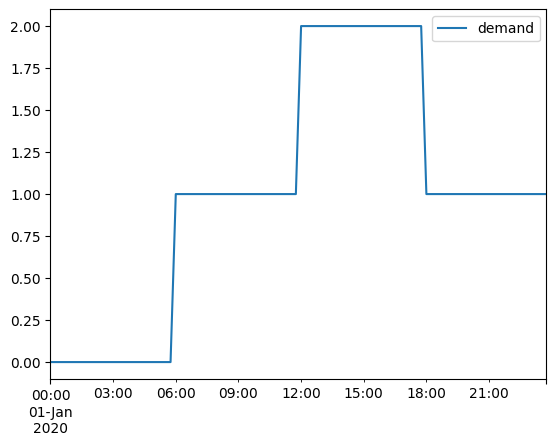

In [165]:
demand_data.plot(y='demand');
plt.show()

In [166]:
print(bhp_prosumer.heat_demand)

   name  scaling  in_service
0  None      1.0        True


Then we list the availabel results for the heat pump element. Results are stored in the form of time series, which can be plotted on a graph. The *.time_series* command lists all input and output dataframes. 

In [167]:
print(bhp_prosumer.time_series)

         name            element  element_index  period_index data_source
0  example_hp  booster_heat_pump            0.0           0.0      DFData
1        None        heat_demand            0.0           0.0      DFData


Here *.data_source* lists all available dataframes that we then specify with index in *.loc[]*.

In [168]:
print(bhp_prosumer.time_series.data_source)

0    DFData
1    DFData
Name: data_source, dtype: object


Before plotting we have to look at the resulting dataframe to see which quantity (column) do we want to plot. Index can be an integer or the defined name of specific component you want to look at.

In [169]:
print(bhp_prosumer.time_series.data_source.loc[0].df.head())

                           cop_floor  cop_radiator  p_el_floor  p_el_radiator  \
2020-01-01 00:00:00+00:00   4.107815      3.782815         0.0            0.0   
2020-01-01 00:15:00+00:00   4.107815      3.782815         0.0            0.0   
2020-01-01 00:30:00+00:00   4.107815      3.782815         0.0            0.0   
2020-01-01 00:45:00+00:00   4.107815      3.782815         0.0            0.0   
2020-01-01 01:00:00+00:00   4.107815      3.782815         0.0            0.0   

                           q_remain  q_floor  q_radiator  
2020-01-01 00:00:00+00:00       0.0      0.0         0.0  
2020-01-01 00:15:00+00:00       0.0      0.0         0.0  
2020-01-01 00:30:00+00:00       0.0      0.0         0.0  
2020-01-01 00:45:00+00:00       0.0      0.0         0.0  
2020-01-01 01:00:00+00:00       0.0      0.0         0.0  


In [170]:
res_df = bhp_prosumer.time_series
res_df.set_index('name', inplace=True)
print(res_df.loc[bhp_name].data_source.df)

                           cop_floor  cop_radiator  p_el_floor  p_el_radiator  \
2020-01-01 00:00:00+00:00   4.107815      3.782815    0.000000       0.000000   
2020-01-01 00:15:00+00:00   4.107815      3.782815    0.000000       0.000000   
2020-01-01 00:30:00+00:00   4.107815      3.782815    0.000000       0.000000   
2020-01-01 00:45:00+00:00   4.107815      3.782815    0.000000       0.000000   
2020-01-01 01:00:00+00:00   4.107815      3.782815    0.000000       0.000000   
2020-01-01 01:15:00+00:00   4.107815      3.782815    0.000000       0.000000   
2020-01-01 01:30:00+00:00   4.107815      3.782815    0.000000       0.000000   
2020-01-01 01:45:00+00:00   4.107815      3.782815    0.000000       0.000000   
2020-01-01 02:00:00+00:00   4.107815      3.782815    0.000000       0.000000   
2020-01-01 02:15:00+00:00   4.107815      3.782815    0.000000       0.000000   
2020-01-01 02:30:00+00:00   4.107815      3.782815    0.000000       0.000000   
2020-01-01 02:45:00+00:00   

Now we can plot the evolution of COP of the booster heat pump.

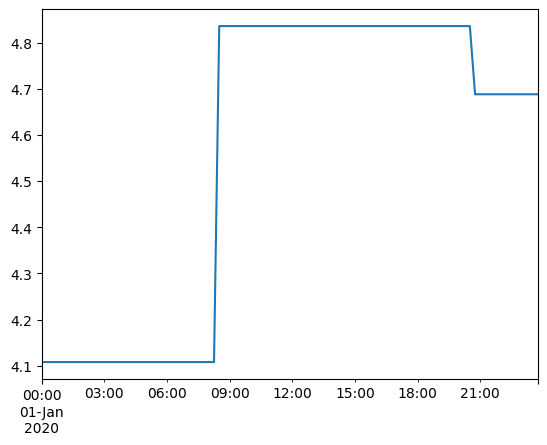

In [171]:
bhp_prosumer.time_series.data_source.loc[bhp_name].df.cop_floor.plot()
plt.show()

We can also for example plot the evolution of electrical power (floor) of the booster heat pump.

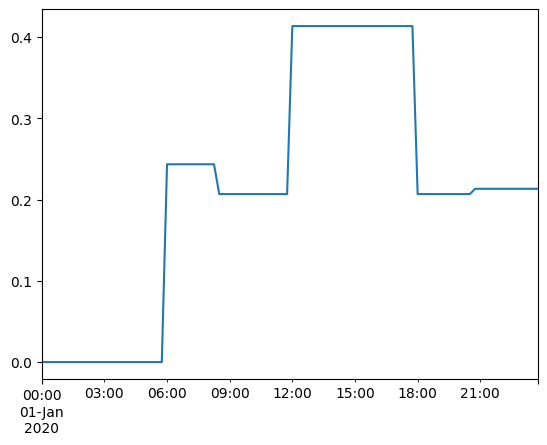

In [172]:
bhp_prosumer.time_series.data_source.loc[bhp_name].df.p_el_floor.plot()
plt.show()

ACKNOWLEDGEMENTS:
-----------------
The authors would like to thank Pratikshya Mohanty and Odile Capron from the Fraunhofer Institute for the help in preparing this tutorial. Special thanks also to Pawel Lytaev and colleagues from the University of Kassel for their code reviews and suggestions during the development of the models. Support from the Senergy Nets project, funded by the European Union under the Horizon Europe program (Grant Agreement No. 101075731) is gratefully acknowledged. 